In [173]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from rdkit import Chem
from rdkit.Chem import Descriptors
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, auc,RocCurveDisplay, ConfusionMatrixDisplay)

In [174]:
chemtaste_df = pd.read_csv('ChemTastes_rdDescs_nonpeptides.csv')
chemtaste_df = chemtaste_df.iloc[:, 1:]
chemtastes_taste_count = chemtaste_df['Class taste'].value_counts(dropna=False)
print(chemtastes_taste_count)
chemtaste_bittersweet_df = chemtaste_df[chemtaste_df['Class taste'].isin(['Bitterness', 'Sweetness'])]
chemtaste_bittersweet_df

Class taste
Bitterness        1298
Sweetness         1069
Non-sweetness      298
Tastelessness      215
Umaminess           99
Sourness            48
Non-bitterness      28
Saltiness           16
Name: count, dtype: int64


,ID,Name,canonical SMILES,Class taste,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0001,(-)-Haematoxylin,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Sweetness,10.888759,10.888759,0.057655,-1.223235,0.469461,25.045455,...,0,0,0,0,0,0,0,0,0,0
1,0002,(+)-4β-hydroxyhernandulcin,CC(C)=CCCC(C)(O)C1CC(O)C(=CC1=O)C,Sweetness,11.931030,11.931030,0.069444,-1.054352,0.755242,27.444444,...,0,0,0,0,0,0,0,0,0,0
2,0003,(+)-Dihydroquercetin 3-acetate,CC(=O)OC1C(Oc2cc(cc(c2C1=O)O)O)c1ccc(c(c1)O)O,Sweetness,12.709217,12.709217,0.094012,-1.412606,0.477325,19.000000,...,0,0,0,0,0,0,0,0,0,0
3,0004,(+)-Dihydro-6-methoxy-luteolin 3-acetate,COc1c(cc2c(c1O)C(=O)C(OC(C)=O)C(O2)c1ccc(c(c1)...,Sweetness,12.921813,12.921813,0.155771,-1.473063,0.465280,18.370370,...,0,0,0,0,0,0,0,0,0,0
4,0005,(+)-Haematoxylin,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Sweetness,10.888759,10.888759,0.057655,-1.223235,0.469461,25.045455,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,2923,β-Colubrine,COc1ccc2c(c1)C13CCN4CC5=CCOC6CC(=O)N2C3C6C5CC14,Bitterness,13.298427,13.298427,0.040278,0.040278,0.716024,43.296296,...,0,0,0,0,0,0,0,0,0,0
2363,2924,β-D-Asp-L-Phe-OMe,COC(=O)C(Cc1ccccc1)NC(=O)CC(N)CC(O)=O,Bitterness,11.864139,11.864139,0.172040,-1.074904,0.585158,13.000000,...,0,0,0,0,0,0,0,0,0,0
2364,2925,β-D-Mannose,OCC1OC(O)C(O)C(O)C1O,Bitterness,9.119537,9.119537,0.525787,-1.568935,0.290153,49.250000,...,0,0,0,0,0,0,0,0,0,0
2365,2926,β-Glucogallin,OCC1OC(OC(=O)c2cc(c(c(c2)O)O)O)C(O)C(O)C1O,Bitterness,11.933569,11.933569,0.365963,-1.781427,0.236373,30.869565,...,0,0,0,0,0,0,0,0,0,0


In [175]:
chemtaste_bittersweet_df.head(5)

,ID,Name,canonical SMILES,Class taste,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0001,(-)-Haematoxylin,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Sweetness,10.888759,10.888759,0.057655,-1.223235,0.469461,25.045455,...,0,0,0,0,0,0,0,0,0,0
1,0002,(+)-4β-hydroxyhernandulcin,CC(C)=CCCC(C)(O)C1CC(O)C(=CC1=O)C,Sweetness,11.931030,11.931030,0.069444,-1.054352,0.755242,27.444444,...,0,0,0,0,0,0,0,0,0,0
2,0003,(+)-Dihydroquercetin 3-acetate,CC(=O)OC1C(Oc2cc(cc(c2C1=O)O)O)c1ccc(c(c1)O)O,Sweetness,12.709217,12.709217,0.094012,-1.412606,0.477325,19.000000,...,0,0,0,0,0,0,0,0,0,0
3,0004,(+)-Dihydro-6-methoxy-luteolin 3-acetate,COc1c(cc2c(c1O)C(=O)C(OC(C)=O)C(O2)c1ccc(c(c1)...,Sweetness,12.921813,12.921813,0.155771,-1.473063,0.465280,18.370370,...,0,0,0,0,0,0,0,0,0,0
4,0005,(+)-Haematoxylin,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Sweetness,10.888759,10.888759,0.057655,-1.223235,0.469461,25.045455,...,0,0,0,0,0,0,0,0,0,0


In [176]:
missing_counts = chemtaste_bittersweet_df.isna().sum()
missing_proportion = missing_counts / len(chemtaste_bittersweet_df)

missing_df = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_proportion': missing_proportion
})
# missing_df.to_csv('output.csv', index=False)
missing_df.head(20)

,missing_count,missing_proportion
ID,0,0.000000
Name,0,0.000000
canonical SMILES,0,0.000000
Class taste,0,0.000000
MaxAbsEStateIndex,0,0.000000
MaxEStateIndex,0,0.000000
MinAbsEStateIndex,0,0.000000
MinEStateIndex,0,0.000000
qed,0,0.000000
SPS,0,0.000000


In [177]:
bittersweet_descriptors = chemtaste_bittersweet_df.iloc[:, 4:]

feature_selector = VarianceThreshold(threshold=0.01)
filter_bittersweet_descriptors = feature_selector.fit_transform(bittersweet_descriptors)
res_descriptors = bittersweet_descriptors.columns[feature_selector.get_support()]
new_bittersweet_descriptors = pd.DataFrame(filter_bittersweet_descriptors, columns=res_descriptors)
new_bittersweet_descriptors


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_phos_acid,fr_piperdine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_unbrch_alkane,fr_urea
0,10.888759,10.888759,0.057655,-1.223235,0.469461,25.045455,302.282,288.170,302.079038,114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.931030,11.931030,0.069444,-1.054352,0.755242,27.444444,252.354,228.162,252.172545,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.709217,12.709217,0.094012,-1.412606,0.477325,19.000000,346.291,332.179,346.068867,130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.921813,12.921813,0.155771,-1.473063,0.465280,18.370370,376.317,360.189,376.079432,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.888759,10.888759,0.057655,-1.223235,0.469461,25.045455,302.282,288.170,302.079038,114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,13.298427,13.298427,0.040278,0.040278,0.716024,43.296296,364.445,340.253,364.178693,140.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2363,11.864139,11.864139,0.172040,-1.074904,0.585158,13.000000,308.334,288.174,308.137222,120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2364,9.119537,9.119537,0.525787,-1.568935,0.290153,49.250000,180.156,168.060,180.063388,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2365,11.933569,11.933569,0.365963,-1.781427,0.236373,30.869565,332.261,316.133,332.074347,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
correlation_matrix = new_bittersweet_descriptors.corr(method='pearson')
print(correlation_matrix)

                   MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
MaxAbsEStateIndex           1.000000        1.000000          -0.476824   
MaxEStateIndex              1.000000        1.000000          -0.476824   
MinAbsEStateIndex          -0.476824       -0.476824           1.000000   
MinEStateIndex             -0.289479       -0.289479           0.331189   
qed                        -0.196143       -0.196143          -0.010538   
...                              ...             ...                ...   
fr_sulfide                 -0.055446       -0.055446          -0.025452   
fr_sulfonamd                0.044772        0.044772          -0.050749   
fr_sulfone                  0.049720        0.049720          -0.037656   
fr_unbrch_alkane           -0.010473       -0.010473          -0.010494   
fr_urea                     0.062172        0.062172           0.038856   

                   MinEStateIndex       qed       SPS     MolWt  \
MaxAbsEStateIndex       -0.28947

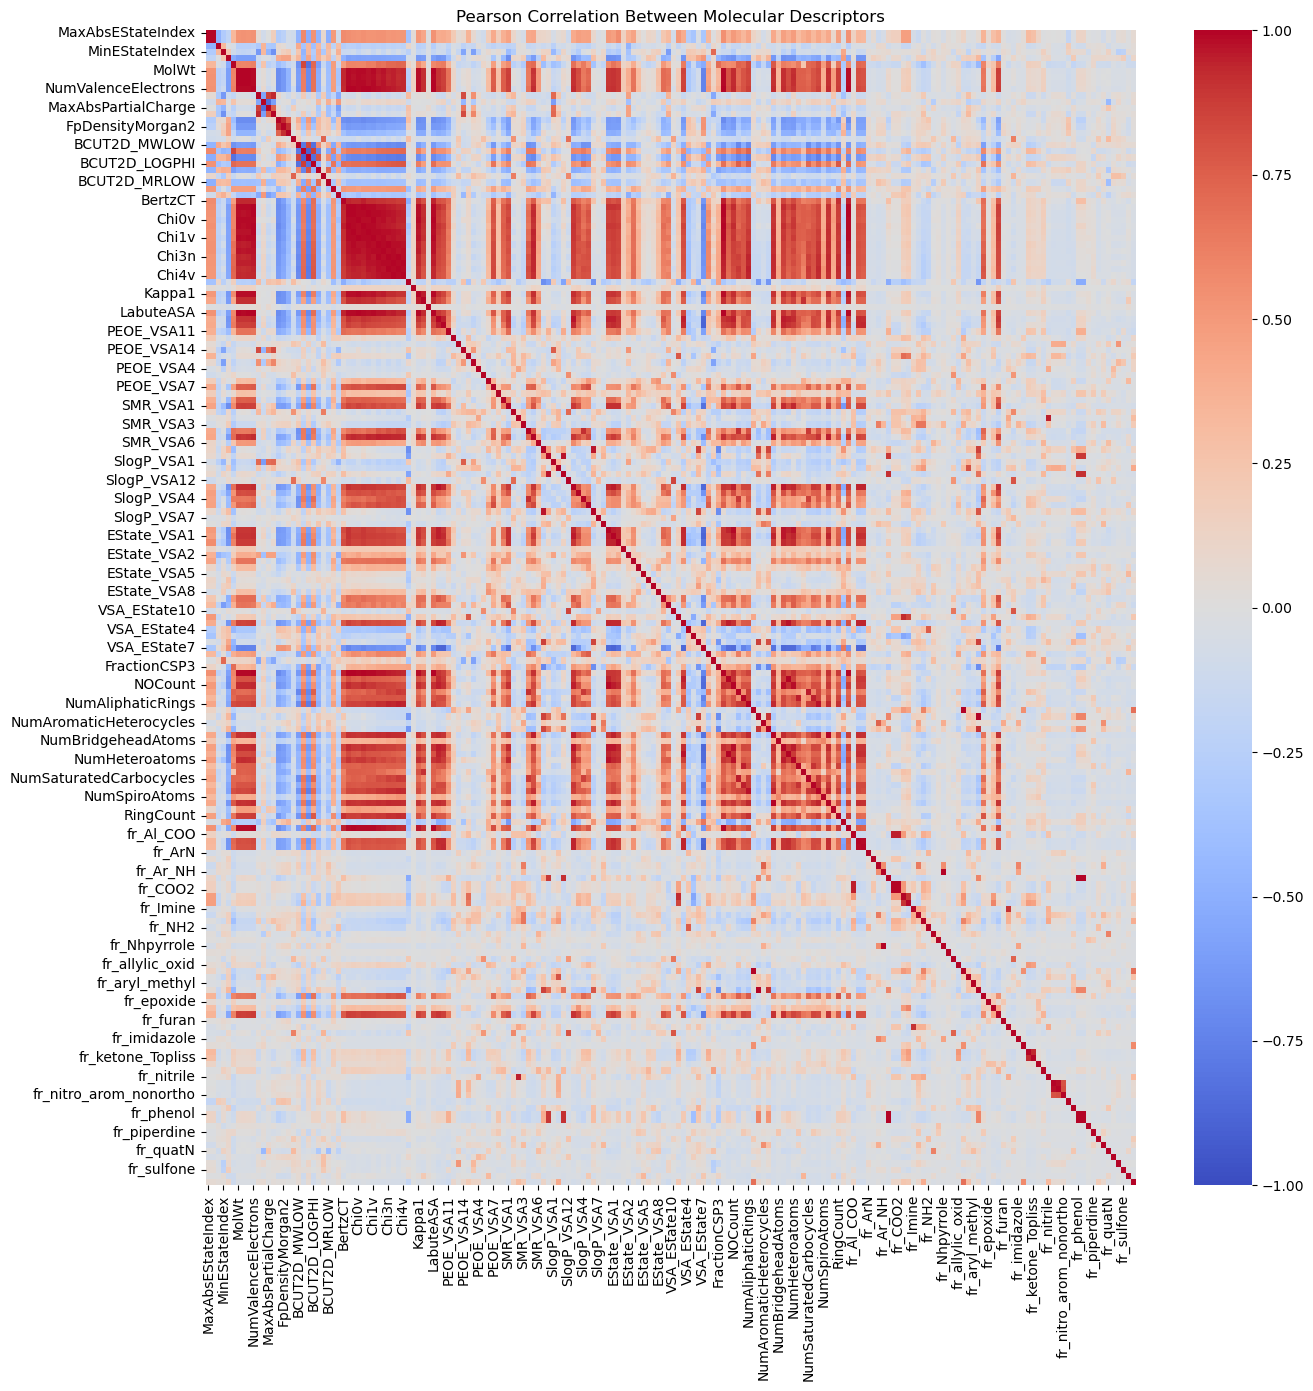

In [179]:
plt.figure(figsize=(15,15))
sns.heatmap(
    correlation_matrix, 
    annot=False,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    # mask=np.triu(np.ones_like(correlation_matrix))
)
plt.title("Pearson Correlation Between Molecular Descriptors")
plt.show()

In [180]:
correlation_matrix_abs = new_bittersweet_descriptors.corr().abs()
upper = correlation_matrix_abs.where(np.triu(np.ones(correlation_matrix_abs.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
new_bittersweet_descriptors_final = new_bittersweet_descriptors.drop(to_drop, axis=1)

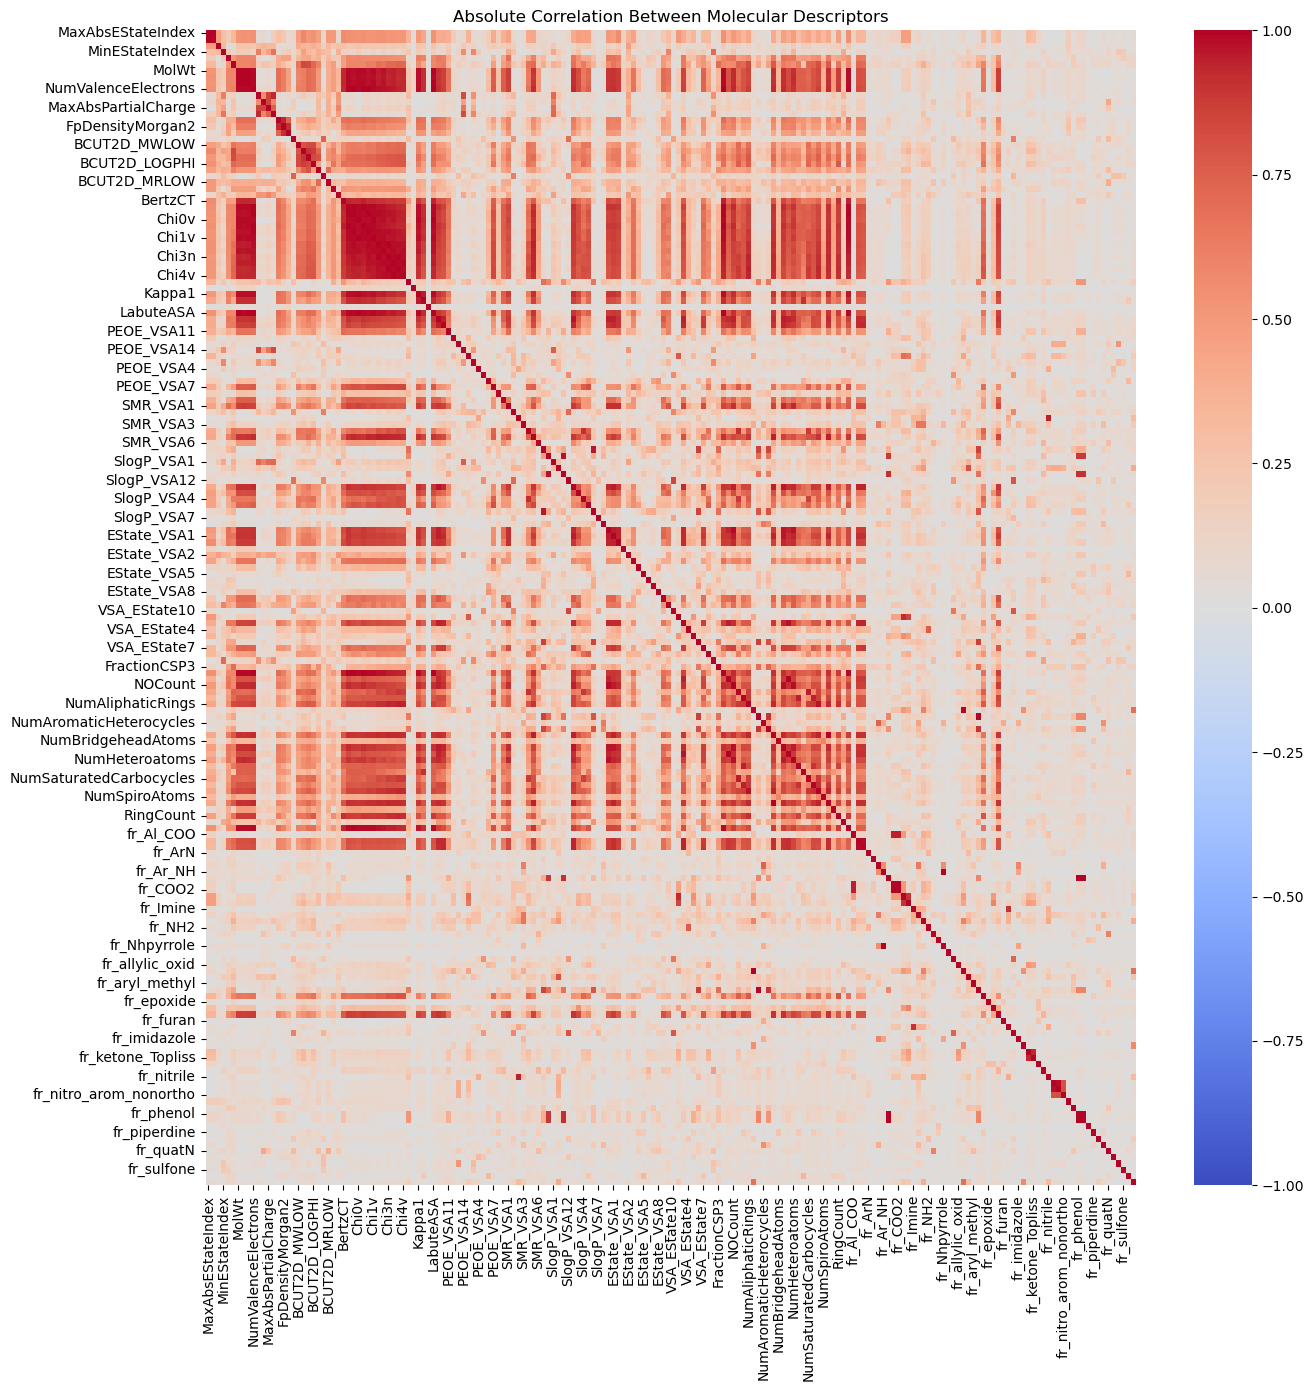

In [181]:
plt.figure(figsize=(15,15))
sns.heatmap(
    correlation_matrix_abs, 
    annot=False,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    # mask=np.triu(np.ones_like(correlation_matrix_abs))
)
plt.title("Absolute Correlation Between Molecular Descriptors")
plt.show()

In [182]:
new_correlation_matrix = new_bittersweet_descriptors_final.corr(method='pearson')
# print(new_correlation_matrix)

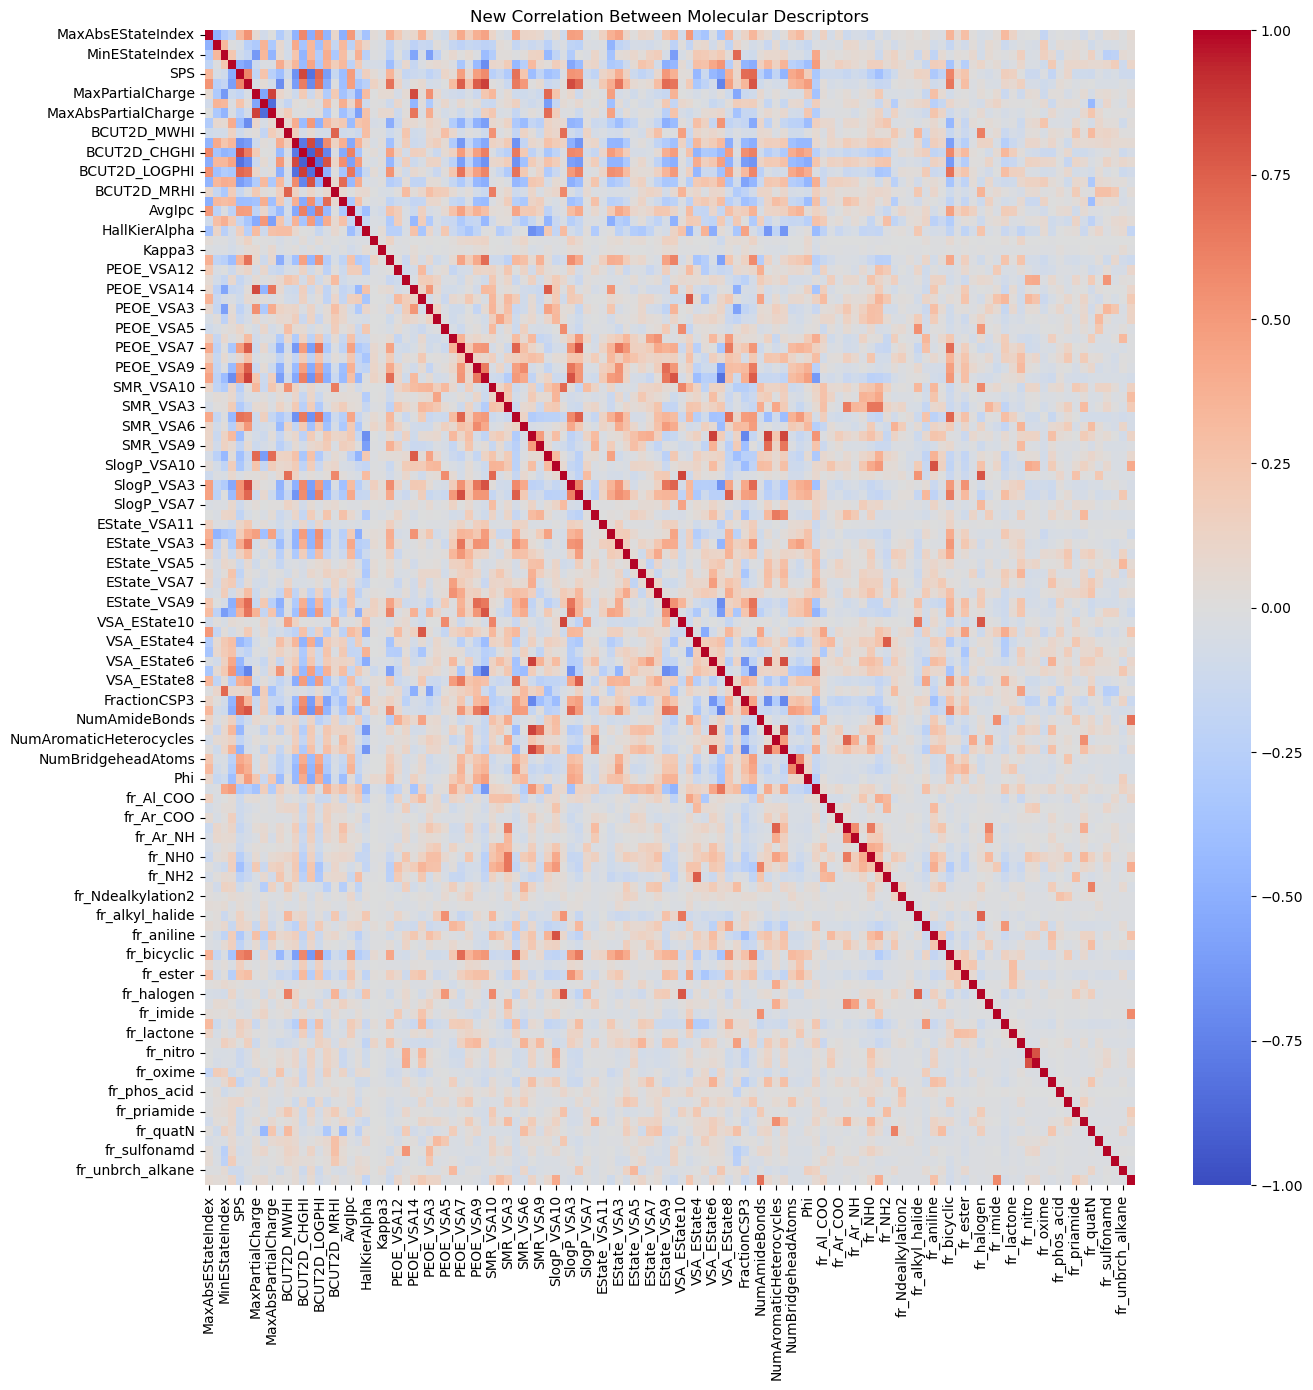

In [183]:
plt.figure(figsize=(15,15))
sns.heatmap(
    new_correlation_matrix, 
    annot=False,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    # mask=np.triu(np.ones_like(new_correlation_matrix))
)
plt.title("New Correlation Between Molecular Descriptors")
plt.show()

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    new_bittersweet_descriptors_final, chemtaste_bittersweet_df['Class taste'], test_size=0.2, random_state=42
)

In [185]:
rf_classifier = RandomForestClassifier(    
    n_estimators=250,
    min_samples_leaf = 1,
    random_state=42,
)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, random_state=42)

In [186]:
y_pred = rf_classifier.predict(X_test)

print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, target_names=['Bitterness', 'Sweetness'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

              precision    recall  f1-score   support

  Bitterness       0.92      0.93      0.93       261
   Sweetness       0.91      0.90      0.91       213

    accuracy                           0.92       474
   macro avg       0.92      0.92      0.92       474
weighted avg       0.92      0.92      0.92       474



Confusion Matrix:
 [[243  18]
 [ 21 192]]
['Bitterness' 'Sweetness']


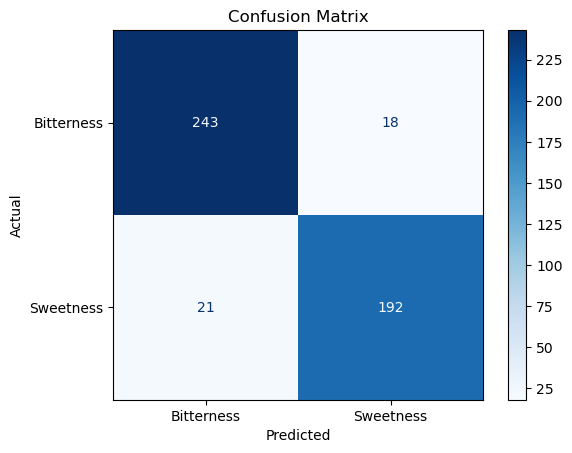

In [187]:
con_matrice = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", con_matrice)

print(np.unique(y_test)) 

class_names=['Bitterness', 'Sweetness']

disp = ConfusionMatrixDisplay(con_matrice, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

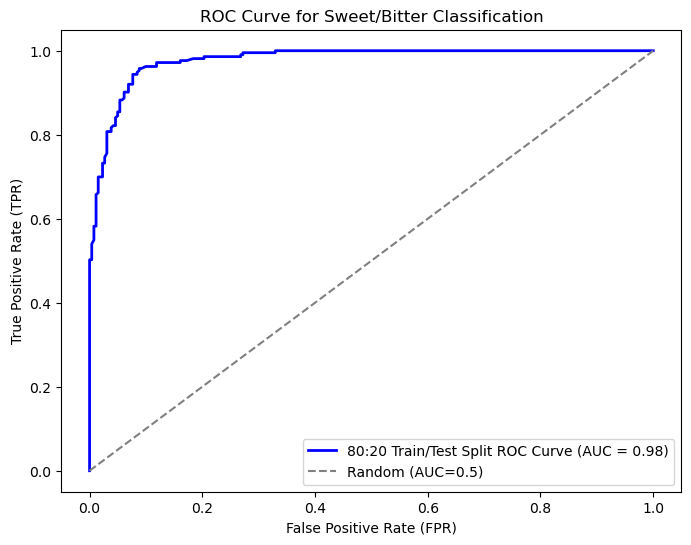

In [188]:

y_scores = rf_classifier.predict_proba(X_test)[:, 1]

fp_rate, tp_rate, thresholds = roc_curve(y_test, y_scores, pos_label='Sweetness')
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fp_rate, tp_rate, color='blue', linewidth=2, label=f'80:20 Train/Test Split ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Sweet/Bitter Classification")
plt.legend()
plt.show()


Fold 1 Confusion Matrix:
[[229  31]
 [ 26 188]]


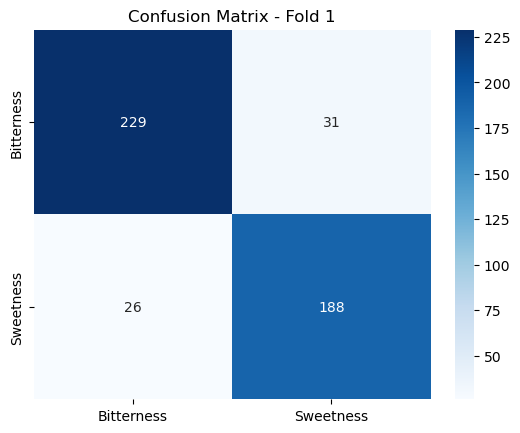

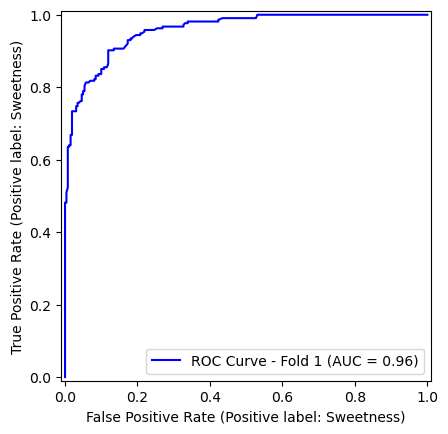


Fold 2 Confusion Matrix:
[[243  17]
 [ 29 185]]


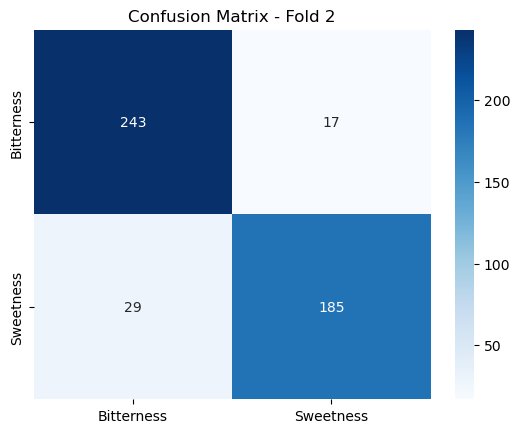

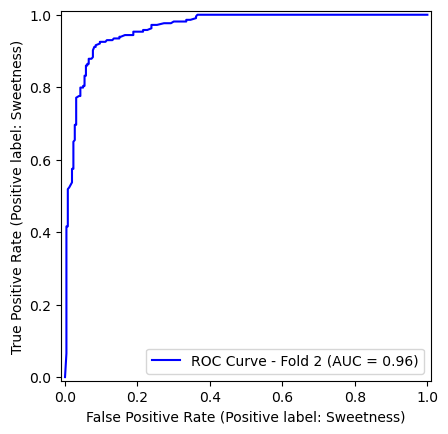


Fold 3 Confusion Matrix:
[[240  19]
 [ 19 195]]


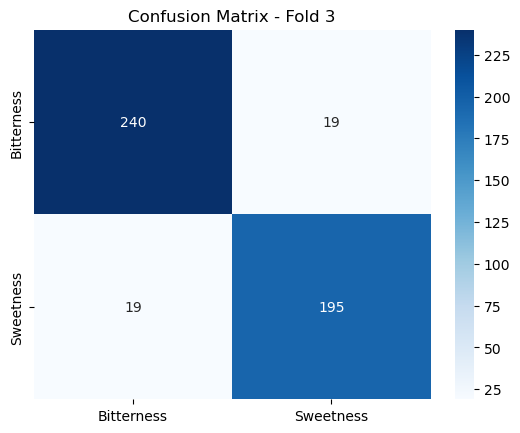

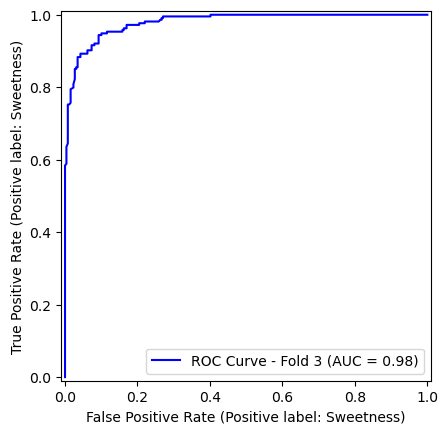


Fold 4 Confusion Matrix:
[[242  17]
 [ 23 191]]


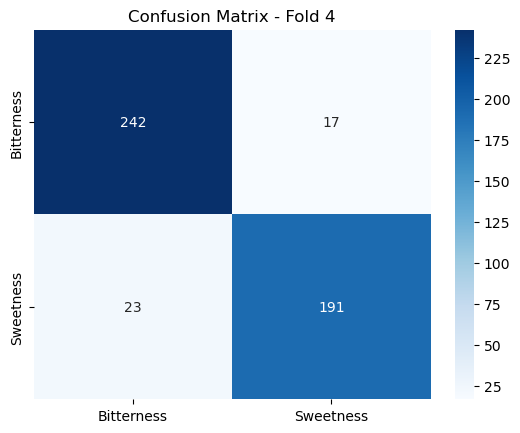

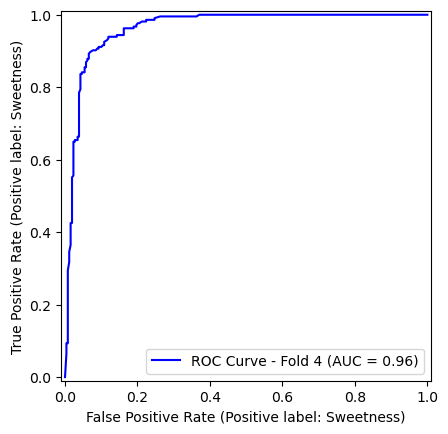


Fold 5 Confusion Matrix:
[[241  19]
 [ 22 191]]


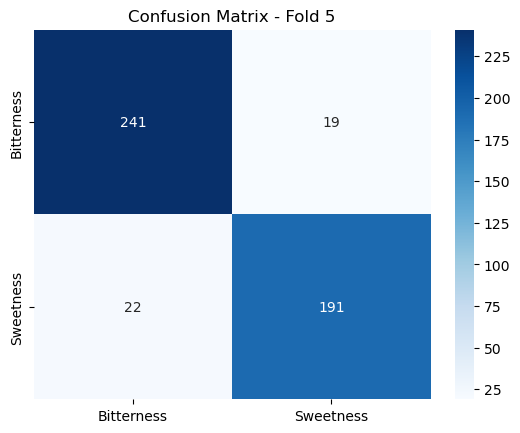

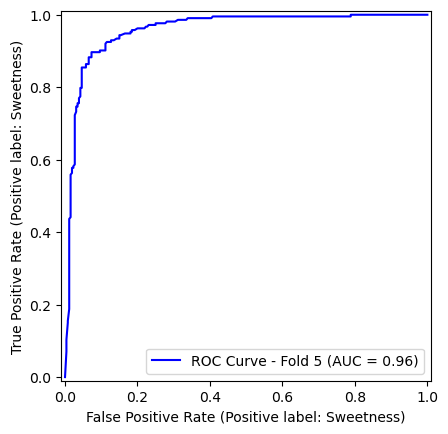


Overall Confusion Matrix (average per fold):
[[239  21]
 [ 24 190]]


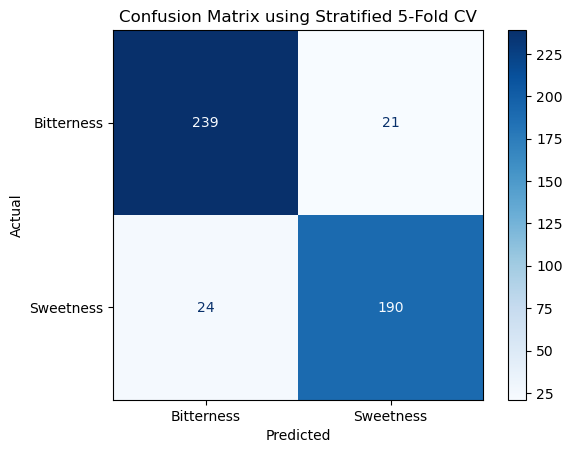

Final Stratified 5-Fold CV Results
Mean Accuracy: 0.9062
Mean Precision: 0.9027
Mean Recall: 0.8887
Mean F1-Score: 0.8955
Mean ROC AUC: 0.9651


In [189]:
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
    'y_true_all': [],
    'y_pred_all': []
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(new_bittersweet_descriptors, chemtaste_bittersweet_df['Class taste']), 1):
    X_train, X_val = new_bittersweet_descriptors.iloc[train_idx], new_bittersweet_descriptors.iloc[val_idx]
    y_train, y_val = chemtaste_bittersweet_df['Class taste'].iloc[train_idx], chemtaste_bittersweet_df['Class taste'].iloc[val_idx]
    
    rf_classifier.fit(X_train, y_train)

    y_pred_5f = rf_classifier.predict(X_val)
    y_proba = rf_classifier.predict_proba(X_val)[:, 1] 
    
    metrics['y_true_all'].extend(y_val)
    metrics['y_pred_all'].extend(y_pred_5f)
    metrics['accuracy'].append(accuracy_score(y_val, y_pred_5f))
    metrics['precision'].append(precision_score(y_val, y_pred_5f, pos_label='Sweetness'))
    metrics['recall'].append(recall_score(y_val, y_pred_5f, pos_label='Sweetness'))
    metrics['f1'].append(f1_score(y_val, y_pred_5f, pos_label='Sweetness'))
    metrics['roc_auc'].append(roc_auc_score(y_val, y_proba))
    
    print(f"\nFold {fold} Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred_5f))
 
    plt.title("Confusion Matrix - Fold {}".format(fold))
    sns.heatmap(
        confusion_matrix(y_val, y_pred_5f), 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=['Bitterness', 'Sweetness'], 
        yticklabels=['Bitterness', 'Sweetness']
    )
    plt.show()

    RocCurveDisplay.from_estimator(
        rf_classifier, 
        X_val, 
        y_val, 
        name=f'ROC Curve - Fold {fold}', 
        color='blue'
    )
    plt.show()


y_true_concat = np.array(metrics['y_true_all'])
y_pred_concat = np.array(metrics['y_pred_all'])
confusion_matrix_5_fold_all = confusion_matrix(y_true_concat, y_pred_concat)
confusion_matrix_5_fold = confusion_matrix_5_fold_all / 5
confusion_matrix_5_fold_int = np.round(confusion_matrix_5_fold).astype(int)

print("\nOverall Confusion Matrix (average per fold):")
print(confusion_matrix_5_fold_int)

class_names=['Bitterness', 'Sweetness']

disp = ConfusionMatrixDisplay(confusion_matrix_5_fold_int, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix using Stratified 5-Fold CV")
plt.show()

print("Final Stratified 5-Fold CV Results")
print(f"Mean Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Mean Precision: {np.mean(metrics['precision']):.4f}")
print(f"Mean Recall: {np.mean(metrics['recall']):.4f}")
print(f"Mean F1-Score: {np.mean(metrics['f1']):.4f}")
print(f"Mean ROC AUC: {np.mean(metrics['roc_auc']):.4f}")



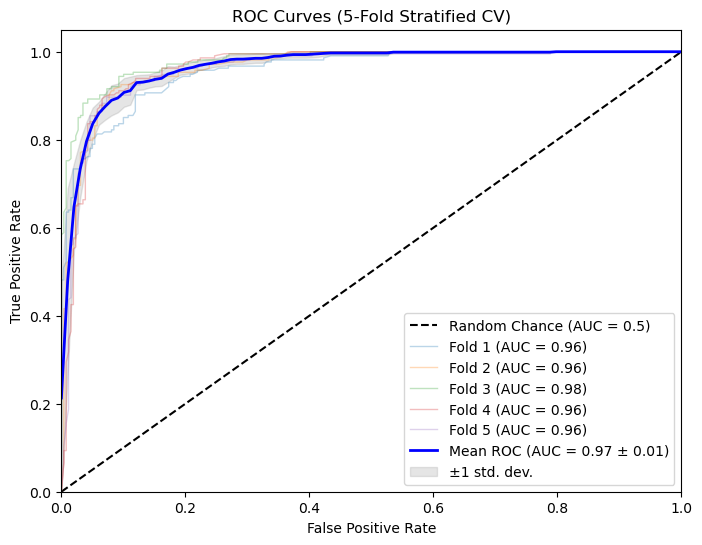

In [212]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.5)')

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(new_bittersweet_descriptors, chemtaste_bittersweet_df['Class taste']), 1):
    X_train, X_val = new_bittersweet_descriptors.iloc[train_idx], new_bittersweet_descriptors.iloc[val_idx]
    y_train, y_val = chemtaste_bittersweet_df['Class taste'].iloc[train_idx], chemtaste_bittersweet_df['Class taste'].iloc[val_idx]
    
    rf_classifier.fit(X_train, y_train)
    y_proba = rf_classifier.predict_proba(X_val)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_val, y_proba, pos_label='Sweetness')
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tprs.append(tpr_interp)
    
    plt.plot(fpr, tpr, alpha=0.3, lw=1, 
             label=f'Fold {fold} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', lw=2,
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                 label='±1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold Stratified CV)")
plt.legend(loc='lower right')
plt.show()

In [192]:
tn_indices = np.where((y_test == "Bitterness") & (y_pred == "Bitterness"))[0]
print("Num of TN:", len(tn_indices))

tp_indices = np.where((y_test == "Sweetness") & (y_pred == "Sweetness"))[0] 
print("Num of TP:", len(tp_indices))

fp_indices = np.where((y_test == "Bitterness") & (y_pred == "Sweetness"))[0]
print("Num of FP:", len(fp_indices))
print("Indices of FP:", fp_indices) 

fn_indices = np.where((y_test == "Sweetness") & (y_pred == "Bitterness"))[0]
print("Num of FN:", len(fn_indices))
print("Indices of FN:", fn_indices)

Num of TN: 243
Num of TP: 192
Num of FP: 18
Indices of FP: [ 30  37  86 128 142 171 175 188 223 226 242 311 350 388 412 431 456 473]
Num of FN: 21
Indices of FN: [ 39  57  61  72  74 112 141 186 195 230 285 303 328 344 345 351 365 373
 425 434 469]


In [193]:
y_test_df = y_test.to_frame(name='Class taste')

chemtaste_bittersweet_tp_data = (y_test_df.join(X_test, how='inner')).iloc[tp_indices]
chemtaste_bittersweet_tn_data = (y_test_df.join(X_test, how='inner')).iloc[tn_indices]
chemtaste_bittersweet_fp_data = (y_test_df.join(X_test, how='inner')).iloc[fp_indices]
chemtaste_bittersweet_fn_data = (y_test_df.join(X_test, how='inner')).iloc[fn_indices]

# print("False Positive Data:\n", chemtaste_bittersweet_fp_data)
# print("False Negative Data:\n", chemtaste_bittersweet_fn_data)

chemtaste_bittersweet_fn_data
chemtaste_bittersweet_tp_data


,Class taste,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,fr_phos_acid,fr_piperdine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_unbrch_alkane,fr_urea
685,Sweetness,12.628330,0.099902,-1.140006,0.538343,22.173913,327.425,0.304964,-0.481176,0.481176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976,Sweetness,10.342370,0.000000,-4.423880,0.471672,10.333333,238.244,1.000000,-0.730964,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353,Sweetness,11.641592,0.126680,-1.160432,0.445082,13.500000,282.296,0.304964,-0.507967,0.507967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,Sweetness,12.803267,0.061308,-1.082358,0.244595,14.514286,486.609,0.304973,-0.504248,0.504248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,Sweetness,12.163287,0.092480,-1.215904,0.536909,11.038462,354.322,0.319237,-0.481165,0.481165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Sweetness,10.716200,0.192941,-0.948574,0.530492,12.318182,302.378,0.322476,-0.479930,0.479930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
788,Sweetness,11.228148,0.043981,-3.656829,0.559965,18.000000,198.203,0.267999,-0.398043,0.398043,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
423,Sweetness,11.339046,0.022265,-0.879294,0.638507,10.263158,459.916,0.302972,-0.491175,0.491175,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
649,Sweetness,8.166667,0.364583,-0.953704,0.381494,10.000000,92.094,0.100047,-0.393593,0.393593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
chemtaste_bittersweet_fp_data.head(5)

,Class taste,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,fr_phos_acid,fr_piperdine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_unbrch_alkane,fr_urea
1911,Bitterness,13.032680,0.035894,-1.859666,0.152417,52.444444,764.950,0.335291,-0.480806,0.480806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1080,Bitterness,9.393913,0.233179,0.233179,0.808046,17.888889,242.274,0.125719,-0.507967,0.507967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1855,Bitterness,10.137222,0.520370,-0.933313,0.457177,13.000000,146.190,0.319967,-0.480086,0.480086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1264,Bitterness,5.310741,0.429306,0.429306,0.555625,27.909091,154.253,0.057405,-0.381447,0.381447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2153,Bitterness,10.371135,0.000000,-4.412526,0.473884,10.500000,223.229,1.000000,-0.730964,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
class_taste_map = {
    'Bitterness': 0.0,
    'Sweetness': 1.0
}

chemtaste_bittersweet_fp_data['Class taste'] = chemtaste_bittersweet_fp_data['Class taste'].replace(class_taste_map)
chemtaste_bittersweet_tp_data['Class taste'] = chemtaste_bittersweet_tp_data['Class taste'].replace(class_taste_map)

C:\Users\examp\AppData\Local\Temp\ipykernel_18884\2462856935.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  chemtaste_bittersweet_fp_data['Class taste'] = chemtaste_bittersweet_fp_data['Class taste'].replace(class_taste_map)
C:\Users\examp\AppData\Local\Temp\ipykernel_18884\2462856935.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  chemtaste_bittersweet_tp_data['Class taste'] = chemtaste_bittersweet_tp_data['Class taste'].replace(class_taste_map)


In [196]:
chemtaste_bittersweet_fp_data_mean = chemtaste_bittersweet_fp_data.mean()
chemtaste_bittersweet_tp_data_mean = chemtaste_bittersweet_tp_data.mean()

comparison_df = pd.DataFrame({
    'FP_mean': chemtaste_bittersweet_fp_data_mean,
    'TP_mean': chemtaste_bittersweet_tp_data_mean,
    'Difference': chemtaste_bittersweet_fp_data_mean - chemtaste_bittersweet_tp_data_mean
}).sort_values('Difference', key=abs, ascending=False)

print(comparison_df.head(50))

                               FP_mean       TP_mean    Difference
Ipc                       1.965752e+10  2.173838e+28 -2.173838e+28
MolWt                     2.799067e+02  4.492791e+02 -1.693724e+02
SMR_VSA1                  2.763631e+01  4.544674e+01 -1.781044e+01
EState_VSA9               9.481919e+00  2.079098e+01 -1.130906e+01
PEOE_VSA9                 1.092220e+01  1.983054e+01 -8.908339e+00
SlogP_VSA5                2.462915e+01  3.304747e+01 -8.418321e+00
SlogP_VSA3                1.063120e+01  1.904028e+01 -8.409078e+00
VSA_EState7               7.199985e-01 -6.275659e+00  6.995658e+00
VSA_EState2               8.084940e+00  1.457189e+01 -6.486948e+00
PEOE_VSA6                 1.388436e+01  1.913209e+01 -5.247726e+00
SPS                       2.278136e+01  2.765660e+01 -4.875242e+00
PEOE_VSA11                4.697230e+00  9.499749e+00 -4.802519e+00
EState_VSA7               5.477080e+00  1.004948e+01 -4.572396e+00
SMR_VSA10                 1.310221e+01  1.708081e+01 -3.978598

In [197]:
positive_features = comparison_df[comparison_df['Difference'] > 0].index.tolist()
print("Features where FP > TP:", positive_features)

num_positive_diff = (comparison_df['Difference'] > 0).sum()
print(f"Number of features where FP > TP: {num_positive_diff}")


Features where FP > TP: ['VSA_EState7', 'EState_VSA6', 'SlogP_VSA1', 'EState_VSA4', 'PEOE_VSA3', 'EState_VSA5', 'VSA_EState5', 'MolLogP', 'BCUT2D_MWHI', 'PEOE_VSA13', 'PEOE_VSA14', 'HallKierAlpha', 'VSA_EState4', 'fr_allylic_oxid', 'FpDensityMorgan1', 'BCUT2D_MRLOW', 'BCUT2D_MRHI', 'fr_oxime', 'fr_aryl_methyl', 'fr_unbrch_alkane', 'BCUT2D_LOGPLOW', 'fr_aniline', 'fr_methoxy', 'fr_sulfonamd', 'BCUT2D_CHGLO', 'MinAbsEStateIndex', 'fr_aldehyde', 'fr_epoxide', 'qed', 'fr_pyridine', 'fr_Ar_COO', 'MaxAbsPartialCharge', 'MaxPartialCharge', 'NumAromaticHeterocycles', 'MinEStateIndex', 'fr_Ar_N', 'fr_NH2']
Number of features where FP > TP: 37


In [198]:
negative_features = comparison_df[comparison_df['Difference'] < 0].index.tolist()
print("Features where FP > TP:", positive_features)

num_negative_diff = (comparison_df['Difference'] < 0).sum()
print(f"Number of features where FP < TP: {num_negative_diff}")

Features where FP > TP: ['VSA_EState7', 'EState_VSA6', 'SlogP_VSA1', 'EState_VSA4', 'PEOE_VSA3', 'EState_VSA5', 'VSA_EState5', 'MolLogP', 'BCUT2D_MWHI', 'PEOE_VSA13', 'PEOE_VSA14', 'HallKierAlpha', 'VSA_EState4', 'fr_allylic_oxid', 'FpDensityMorgan1', 'BCUT2D_MRLOW', 'BCUT2D_MRHI', 'fr_oxime', 'fr_aryl_methyl', 'fr_unbrch_alkane', 'BCUT2D_LOGPLOW', 'fr_aniline', 'fr_methoxy', 'fr_sulfonamd', 'BCUT2D_CHGLO', 'MinAbsEStateIndex', 'fr_aldehyde', 'fr_epoxide', 'qed', 'fr_pyridine', 'fr_Ar_COO', 'MaxAbsPartialCharge', 'MaxPartialCharge', 'NumAromaticHeterocycles', 'MinEStateIndex', 'fr_Ar_N', 'fr_NH2']
Number of features where FP < TP: 75


In [199]:
np.random.seed(42)

tp_match_fp_count = np.random.choice(tp_indices, size=len(tp_indices), replace=False)
chemtaste_bittersweet_tp_data = (y_test_df.join(X_test, how='inner')).iloc[tp_match_fp_count]

In [200]:
class_taste_map = {
    'Sweetness': 1.0,
    'Bitterness': 0.0
}

chemtaste_bittersweet_tp_data['Class taste'] = chemtaste_bittersweet_tp_data['Class taste'].replace(class_taste_map)

C:\Users\examp\AppData\Local\Temp\ipykernel_18884\2266693040.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  chemtaste_bittersweet_tp_data['Class taste'] = chemtaste_bittersweet_tp_data['Class taste'].replace(class_taste_map)


In [201]:


imputer = SimpleImputer(strategy='mean')
chemtaste_bittersweet_fp_imputed = pd.DataFrame(imputer.fit_transform(chemtaste_bittersweet_fp_data), columns=chemtaste_bittersweet_fp_data.columns)
chemtaste_bittersweet_tp_imputed = pd.DataFrame(imputer.fit_transform(chemtaste_bittersweet_tp_data), columns=chemtaste_bittersweet_tp_data.columns)

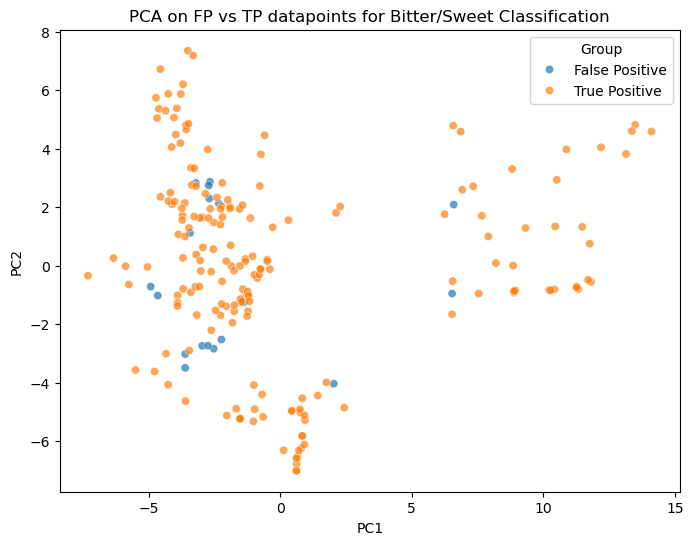

In [202]:
chemtaste_bittersweet_fp_subset = chemtaste_bittersweet_fp_imputed.copy()
chemtaste_bittersweet_fp_subset['Group'] = 'False Positive'

chemtaste_bittersweet_tp_subset = chemtaste_bittersweet_tp_imputed.copy()
chemtaste_bittersweet_tp_subset['Group'] = 'True Positive'

combined = pd.concat([chemtaste_bittersweet_fp_subset, chemtaste_bittersweet_tp_subset])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined.drop(columns='Group'))  


pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

combined['PC1'] = pca_result[:, 0]
combined['PC2'] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Group', data=combined, alpha=0.7)
plt.title('PCA on FP vs TP datapoints for Bitter/Sweet Classification')
plt.show()

C:\Users\examp\AppData\Local\Temp\ipykernel_18884\3438772611.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


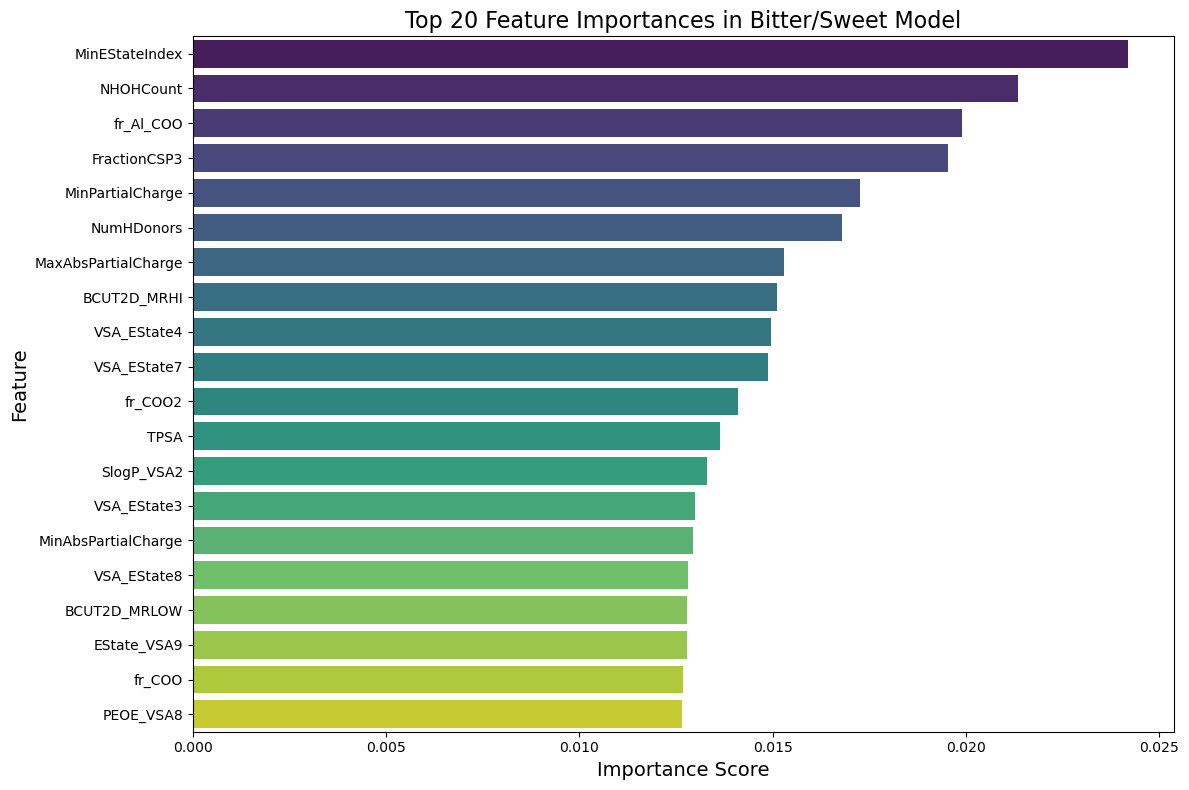

In [203]:
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(20),
    palette='viridis'
)
plt.title('Top 20 Feature Importances in Bitter/Sweet Model', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

In [204]:
shap_explainer = shap.TreeExplainer(rf_classifier)
shap_values = shap_explainer.shap_values(X_train)

shap_values.shape

(1894, 186, 2)

C:\Users\examp\AppData\Local\Temp\ipykernel_18884\2042769894.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., 1], X_train, show=False)


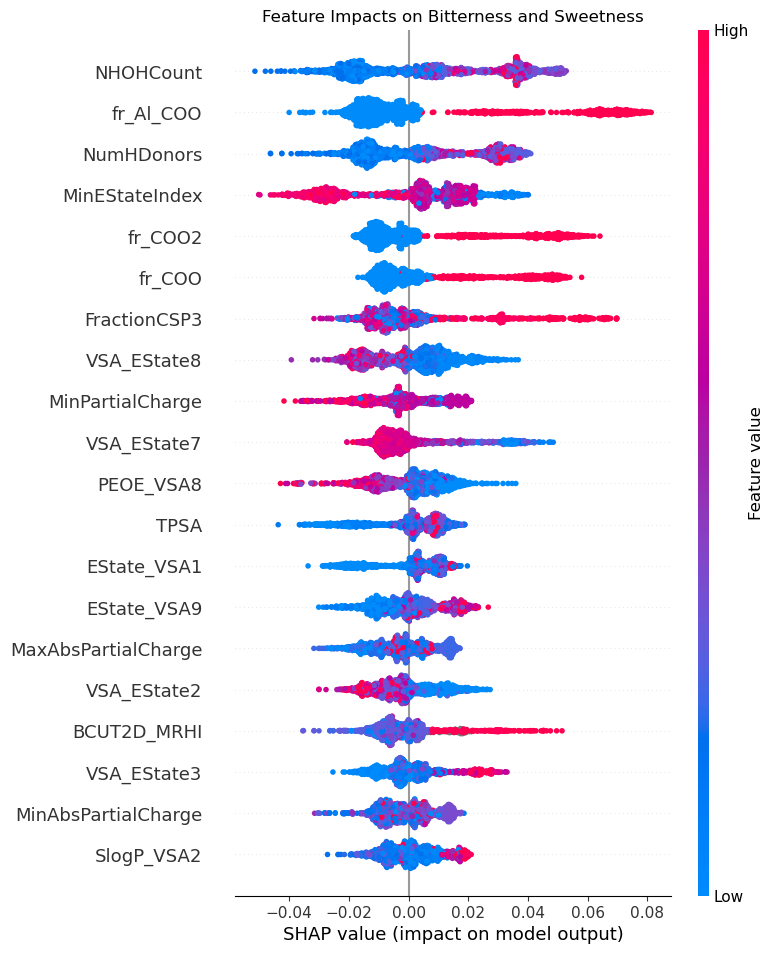

In [205]:
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values[..., 1], X_train, show=False)
plt.title("Feature Impacts on Bitterness and Sweetness")
plt.show()

Functional group anaylysis


In [206]:
def get_fg_count(smiles):
    mol = Chem.MolFromSmiles(smiles)
    functional_group_counts = defaultdict(int)

    if mol is None:
        return None
    
    descriptors = Descriptors.CalcMolDescriptors(mol)

    for desc_name, desc_value in descriptors.items():
        if desc_name.startswith("fr_") and desc_value > 0:
            functional_group_counts[desc_name[3:]] += 1
    
    return dict(functional_group_counts)

In [207]:
chemtaste_bittersweet_df['Functional Groups'] = chemtaste_bittersweet_df['canonical SMILES'].apply(get_fg_count)

C:\Users\examp\AppData\Local\Temp\ipykernel_18884\914703857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemtaste_bittersweet_df['Functional Groups'] = chemtaste_bittersweet_df['canonical SMILES'].apply(get_fg_count)


In [208]:
all_functional_groups = set()
for counts in chemtaste_bittersweet_df["Functional Groups"].dropna():
    all_functional_groups.update(counts.keys())

for fg in sorted(all_functional_groups):
    chemtaste_bittersweet_df[f"fg_{fg}"] = chemtaste_bittersweet_df["Functional Groups"].apply(lambda x: x.get(fg, 0))

chemtaste_bittersweet_df.tail()

C:\Users\examp\AppData\Local\Temp\ipykernel_18884\507579365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemtaste_bittersweet_df[f"fg_{fg}"] = chemtaste_bittersweet_df["Functional Groups"].apply(lambda x: x.get(fg, 0))
C:\Users\examp\AppData\Local\Temp\ipykernel_18884\507579365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemtaste_bittersweet_df[f"fg_{fg}"] = chemtaste_bittersweet_df["Functional Groups"].apply(lambda x: x.get(fg, 0))
C:\Users\examp\AppData\Local\Temp\ipykernel_18884\50757936

,ID,Name,canonical SMILES,Class taste,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fg_sulfide,fg_sulfonamd,fg_sulfone,fg_term_acetylene,fg_tetrazole,fg_thiazole,fg_thiocyan,fg_thiophene,fg_unbrch_alkane,fg_urea
2362,2923,β-Colubrine,COc1ccc2c(c1)C13CCN4CC5=CCOC6CC(=O)N2C3C6C5CC14,Bitterness,13.298427,13.298427,0.040278,0.040278,0.716024,43.296296,...,0,0,0,0,0,0,0,0,0,0
2363,2924,β-D-Asp-L-Phe-OMe,COC(=O)C(Cc1ccccc1)NC(=O)CC(N)CC(O)=O,Bitterness,11.864139,11.864139,0.172040,-1.074904,0.585158,13.000000,...,0,0,0,0,0,0,0,0,0,0
2364,2925,β-D-Mannose,OCC1OC(O)C(O)C(O)C1O,Bitterness,9.119537,9.119537,0.525787,-1.568935,0.290153,49.250000,...,0,0,0,0,0,0,0,0,0,0
2365,2926,β-Glucogallin,OCC1OC(OC(=O)c2cc(c(c(c2)O)O)O)C(O)C(O)C1O,Bitterness,11.933569,11.933569,0.365963,-1.781427,0.236373,30.869565,...,0,0,0,0,0,0,0,0,0,0
2366,2927,"γ,γ'-Dipyridyl",c1cc(ccn1)-c1ccncc1,Bitterness,3.955261,3.955261,1.173519,1.173519,0.631773,9.666667,...,0,0,0,0,0,0,0,0,0,0


Class taste  Bitterness  Sweetness Functional group
0                   132        404           Al_COO
1                   472        421            Al_OH
2                   427        410     Al_OH_noTert
3                    27         26              ArN
4                    40         15           Ar_COO
..                  ...        ...              ...
75                   10         11         thiazole
76                    1          0         thiocyan
77                    1          2        thiophene
78                   86         31    unbrch_alkane
79                   31         51             urea

[80 rows x 3 columns]


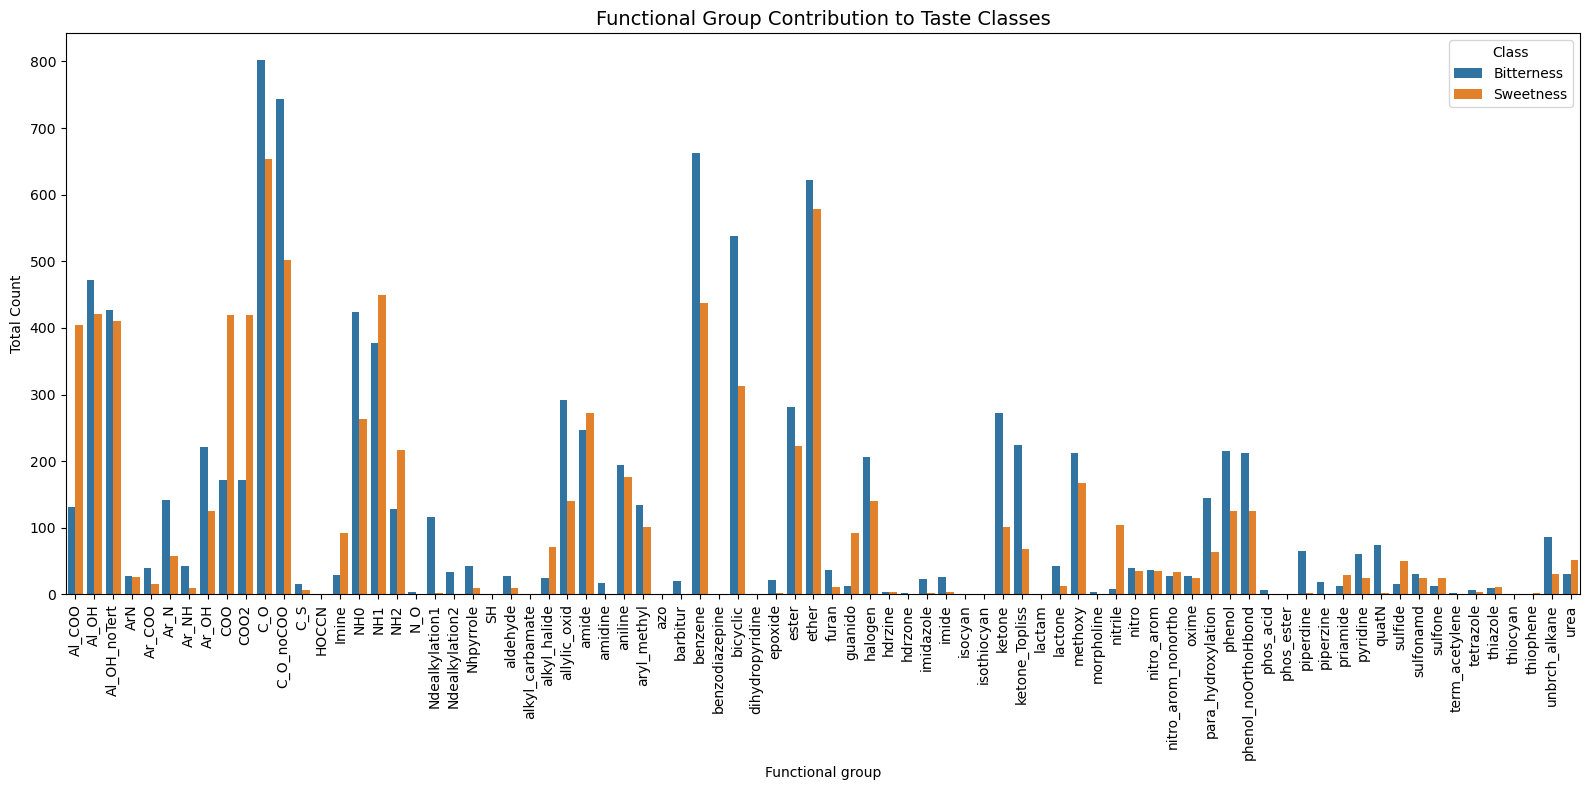

In [209]:
fg_totals = chemtaste_bittersweet_df.groupby("Class taste")[[col for col in chemtaste_bittersweet_df.columns if "fg_" in col]].sum()

fg_totals = fg_totals.T.reset_index()
fg_totals["Functional group"] = fg_totals["index"].str.replace("fg_", "")
fg_totals = fg_totals.drop(columns="index")

df_melted = pd.melt(
    fg_totals, 
    id_vars="Functional group", 
    value_vars=["Bitterness", "Sweetness"],
    var_name="Class", 
    value_name="Total Count"
)

plt.figure(figsize=(16, 8))

ax = sns.barplot(
    data=df_melted,
    x="Functional group",
    y="Total Count",
    hue="Class"
)

print(fg_totals)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Functional Group Contribution to Taste Classes", fontsize=14)
plt.tight_layout()
plt.show()